In [3]:
 !pip install -q git+https://github.com/tensorflow/docs@r1.14

In [4]:
!pip freeze | grep tensorflow

tensorflow==2.9.2
tensorflow-datasets==4.6.0
tensorflow-docs @ git+https://github.com/tensorflow/docs@d1b9b9f90e6203ce4f3f9334045deede3aa7d9a1
tensorflow-estimator==2.9.0
tensorflow-gcs-config==2.9.1
tensorflow-hub==0.12.0
tensorflow-io-gcs-filesystem==0.27.0
tensorflow-metadata==1.11.0
tensorflow-probability==0.17.0


In [5]:
# from tensorflow_docs.vis import embed

ModuleNotFoundError: ignored

In [6]:
 !pip install -q git+https://github.com/tensorflow/docs

In [7]:
from tensorflow_docs.vis import embed
from tensorflow import keras
from imutils import paths

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
#Define hyper parameters
IMG_SIZE = 540 
BATCH_SIZE = 32
EPOCHS = 200

MAX_SEQ_LENGTH = 500 # if number of frames is less than 500, fill with 0 (padding concept). 
NUM_FEATURES = 1536 # Number of features we want

In [13]:
data_path = '/content/drive/MyDrive/Dataset/dataset_4'
tag = [] # classes
video_name_phases = []
for fol in os.listdir(data_path):
  for video in os.listdir(os.path.join(data_path, fol)):
    tag.append(fol)
    video_name_phases.append(data_path + '/' + fol + '/' + video)
print(tag)
print(video_name_phases )
df_train = pd.DataFrame({'tag': tag, 'video_name': video_name_phases })
print(df_train) # show some data from data frame

['10', '5', '1', '3', '6', '8', '9', '4', '2', '7']
['/content/drive/MyDrive/Dataset/dataset_4/10/350.avi', '/content/drive/MyDrive/Dataset/dataset_4/5/350.avi', '/content/drive/MyDrive/Dataset/dataset_4/1/350.avi', '/content/drive/MyDrive/Dataset/dataset_4/3/350.avi', '/content/drive/MyDrive/Dataset/dataset_4/6/350.avi', '/content/drive/MyDrive/Dataset/dataset_4/8/350.avi', '/content/drive/MyDrive/Dataset/dataset_4/9/350.avi', '/content/drive/MyDrive/Dataset/dataset_4/4/350.avi', '/content/drive/MyDrive/Dataset/dataset_4/2/350.avi', '/content/drive/MyDrive/Dataset/dataset_4/7/350.avi']
  tag                                         video_name
0  10  /content/drive/MyDrive/Dataset/dataset_4/10/35...
1   5  /content/drive/MyDrive/Dataset/dataset_4/5/350...
2   1  /content/drive/MyDrive/Dataset/dataset_4/1/350...
3   3  /content/drive/MyDrive/Dataset/dataset_4/3/350...
4   6  /content/drive/MyDrive/Dataset/dataset_4/6/350...
5   8  /content/drive/MyDrive/Dataset/dataset_4/8/350...
6   9  

In [14]:
# Here we have two functions
def crop_center_square_xy(frame): # crop the center 
    y_shape, x_shape = frame.shape[0:2]
    min_dim = min(y_shape, x_shape)
    start_x_1 = (x_shape // 2) - (min_dim // 2)
    start_y_1 = (y_shape // 2) - (min_dim // 2)
    return frame[start_y_1 : start_y_1 + min_dim, start_x_1 : start_x_1 + min_dim]
# Phases extraction
# Now we have data ( with series of frames and classes. example, class 1, has  series of frames and so on.. ), Now we will  extract frames of each phases  for phase predictions.
#'''this function to extract frame from each phase video output'''
def load_video(path, max_frames=20):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square_xy(frame)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)
# Once we are done  with frame then we will do feature extractions..

In [15]:
# Now we we have frames of each phases ( It means images of frames of each phases)
#Next step is to extract features using InceptionResNetV2 
#https://keras.io/api/applications/densenet/ # pretrained model, Transfering model here
def feature_extractor():
    feature_extractor_build = keras.applications.InceptionResNetV2(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3), # Image Size with RGB
    )
    input_as_preprocess = keras.applications.inception_v3.preprocess_input

    input_value = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed_value = input_as_preprocess(input_value)

    output_value = feature_extractor_build(preprocessed_value)
    return keras.Model(input_value , output_value, name="feature_extractor")

# Now intializing the this   parameter
feature_extractor = feature_extractor()

219055592/219055592 [==============================] - 8s 0us/step


In [16]:
# This is label Encoding, As our class is has string values and machine learning do not deal with this.
# Label preprocessing with StringLookup.
label_processor_phases = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(os.listdir(data_path))
)
print(label_processor_phases.get_vocabulary())

['1', '10', '2', '3', '4', '5', '6', '7', '8', '9']


/usr/local/lib/python3.7/dist-packages/numpy/core/numeric.py:2446: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


In [17]:
# from here what we discussed like encoding, creatng frames and all that, i have created one functions and put all in this function 
# Putting all data together, like padding, add batch dimention, feature extractions.
# Encapsulating
def prepare_all_videos_all_phases(df):
  total_number_samples = len(df)
  video_paths = df["video_name"].values.tolist()
  labels_value = df["tag"].values
  labels = label_processor_phases(labels_value[..., None]).numpy()
  frame_masks_value = np.zeros(shape=(total_number_samples, MAX_SEQ_LENGTH), dtype="bool")
  frame_features_value = np.zeros(
      shape=(total_number_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
  )

  # For every  video.
  for idx, path in enumerate(video_paths):
      total_frames_value = load_video(path) # Gather all  frames and also  add a batch dimension.
      frames = total_frames_value[None, ...]

      # placeholders for storing the masks and features of the current video.
      temp_frame_mask_value = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
      temp_frame_features_value = np.zeros(
          shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
      )

      # Extracting all  features from the frames .
      for k, batch in enumerate(frames):
          video_length = batch.shape[0]
          length = min(MAX_SEQ_LENGTH, video_length)
          for j in range(length):
              temp_frame_features_value[k, j, :] = feature_extractor.predict(
                  batch[None, j, :]
              )
          temp_frame_mask_value[k, :length] = 1  

      frame_features_value[idx,] = temp_frame_features_value.squeeze()
      frame_masks_value[idx,] = temp_frame_mask_value.squeeze()

  return (frame_features_value, frame_masks_value), labels


# using this function for  Train set and test set
test_data, test_labels = prepare_all_videos_all_phases(df_train)
train_data, train_labels = prepare_all_videos_all_phases(df_train) 


print(f"Features of frames in train set: {train_data[0].shape}")
print(f" Features of Frame masks in train set: {train_data[1].shape}")

1/1 [==============================] - 2s 2s/step
Features of frames in train set: (10, 500, 1536)
 Features of Frame masks in train set: (10, 500)


In [18]:
# Created function for compliling model, Model intilization..
def sequence_model():  # Using  LSTM Model . Compiling model and return output
    vocab = label_processor_phases.get_vocabulary()

    frame_features_as_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES)) # input to RNN 
    mask_as_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool") # Input to RNN

    x = keras.layers.LSTM(100, activation='relu',return_sequences=True)(
        frame_features_as_input, mask=mask_as_input
    )
    x = keras.layers.LSTM(50, activation='relu')(x) # Layers
    x = keras.layers.Dropout(0.1)(x)
    x = keras.layers.Dense(2048, activation="relu")(x)
    x = keras.layers.Dense(1024, activation="relu")(x)
    x = keras.layers.Dense(512, activation="relu")(x)

    x = keras.layers.Dense(126, activation="relu")(x)
    x = keras.layers.Dense(32, activation="relu")(x)
    x = keras.layers.Dense(16, activation="relu")(x)
    output_value = keras.layers.Dense(len(vocab), activation="softmax")(x) # final layer

    lstm_model = keras.Model([frame_features_as_input, mask_as_input], output_value)

    lstm_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]  # this cost function we are using 
    )
    return lstm_model


# This function for runing the model, OR performing the traainingg
def run_our_experiment():
    file_path = "/tmp/video_classifier" # Under temp folder , model will be stored
    checkpoint_ = keras.callbacks.ModelCheckpoint(
        file_path, save_weights_only=True, save_best_only=True, verbose=1
    )
    ## Model weights are saved at the end of every epoch, if it's the best seen
# so far
#https://keras.io/api/callbacks/model_checkpoint/#:~:text=ModelCheckpoint%20callback%20is%20used%20in,training%20from%20the%20state%20saved.
    seq_model = sequence_model() # Calling  Function which we already defined
    history = seq_model.fit( # fitting model, 
        [train_data[0], train_data[1]], #  Training Data ( frames)
        train_labels, # Training labels ( Phases)
        validation_split=0.3, # Validation split
        epochs=EPOCHS, # Epochs
        callbacks=[checkpoint_],
    )

    seq_model.load_weights(file_path)
    _, accuracy = seq_model.evaluate([test_data[0], test_data[1]], test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, seq_model


history, sequence_model = run_our_experiment() #return history to plot graph


Epoch 1/200
1/1 [==============================] - ETA: 0s - loss: 2.3030 - accuracy: 0.1429
Epoch 1: val_loss improved from inf to 2.51250, saving model to /tmp/video_classifier
1/1 [==============================] - 6s 6s/step - loss: 2.3030 - accuracy: 0.1429 - val_loss: 2.5125 - val_accuracy: 0.0000e+00
Epoch 2/200
1/1 [==============================] - ETA: 0s - loss: 2.2563 - accuracy: 0.1429
Epoch 2: val_loss did not improve from 2.51250
1/1 [==============================] - 2s 2s/step - loss: 2.2563 - accuracy: 0.1429 - val_loss: 3.3687 - val_accuracy: 0.0000e+00
Epoch 3/200
1/1 [==============================] - ETA: 0s - loss: 2.0964 - accuracy: 0.1429
Epoch 3: val_loss did not improve from 2.51250
1/1 [==============================] - 2s 2s/step - loss: 2.0964 - accuracy: 0.1429 - val_loss: 5.7964 - val_accuracy: 0.0000e+00
Epoch 4/200
1/1 [==============================] - ETA: 0s - loss: 2.1498 - accuracy: 0.1429
Epoch 4: val_loss did not improve from 2.51250
1/1 [======

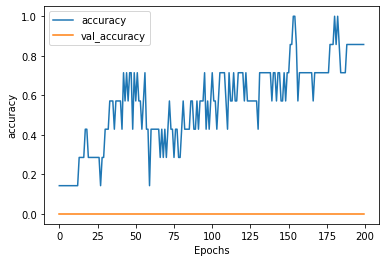

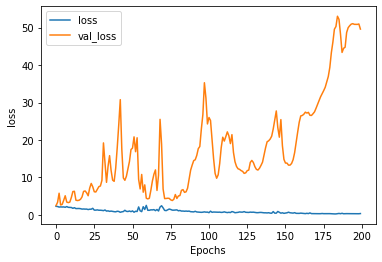

In [19]:
#Visualize Training
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history["val_"+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string,"val_"+string])
    plt.show()
plot_graphs(history,'accuracy')
plot_graphs(history,'loss')

1/1 [==============================] - 1s 763ms/step


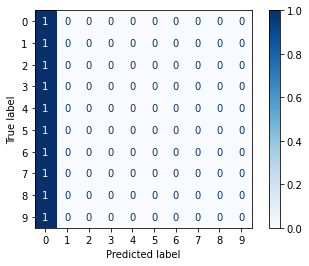

In [20]:
class_labels = [i for i in range(10)] #10 classes

from sklearn import metrics
#Confution Matrix
Y_pred = sequence_model.predict([test_data[0], test_data[1]]) #predict result
y_pred = np.argmax(Y_pred, axis=1) #get class
cm = metrics.confusion_matrix(test_labels, y_pred)

# class_labels = list(test_generator.class_indices.keys()) 
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels) #plot confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [21]:
# Preparing for prediction
 #This function is responsible to prepare video which algorithm will accept for predtion
# If the number of frames are less, we are using this Max_Seq 
#OR padding
def prepare_single_video_for_prediction(frames):
    frames_1 = frames[None, ...]
    frame_mask_1 = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
    frame_features_values = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames_1):
        video_len = batch.shape[0]
        len = min(50, video_len)
        for j in range(len):
            frame_features_values[i, j, :] = feature_extractor.predict(batch[None, j, :])
        frame_mask_1[i, :len] = 1  

    return frame_features_values, frame_mask_1


def sequence_prediction_for_frames(path):
    vocab = label_processor_phases.get_vocabulary()

    frames_all = load_video(os.path.join("test", path))
    frame_features_value, frame_mask_1 = prepare_single_video_for_prediction(frames_all)
    probabilities = sequence_model.predict([frame_features_value, frame_mask_1])[0] # Prediction

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames_all

def to_gif(images):
    converted_images_value = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images_value, fps=10) # at rate of 10 fbs.
    return embed.embed_file("animation.gif")


test_video = '/content/drive/MyDrive/Dataset/dataset_4/1/video.avi' # this video we want to know related phases.
print(f"Test video path: {test_video}")
test_frames = sequence_prediction_for_frames(test_video)
to_gif(test_frames[:MAX_SEQ_LENGTH])

Test video path: /content/drive/MyDrive/Dataset/dataset_4/1/video.avi
1/1 [==============================] - 0s 166ms/step
  1: 10.06%
  6: 10.05%
  9: 10.04%
  10: 10.04%
  8: 10.01%
  5: 10.00%
  7:  9.99%
  3:  9.99%
  4:  9.92%
  2:  9.91%


RuntimeError: ignored

In [ ]:
# References
#https://keras.io/examples/vision/video_classification/
#https://www.youtube.com/watch?v=ezjnySXqdTo&ab_channel=CodeWithAarohi
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub